之前我们可以在$N(\mathbf{0},\mathbf{I})$上采样，但无法控制采样出的数字。现在我们向模型中引入条件，换言之，编码现在除了以前的$z$
以外还有了一个以分类概率向量编码的分类变量$y$，这个东西也可以在MNIST数据集中直接获得。

首先我们来比较VAE，VAE中可以看做是在优化边缘概率$p_\theta(X)$。不过由于它无法直接优化，我们转而优化它的下界：

$$
\log p_\theta(x) = D_{KL}(q_\phi(z \mid x)||p_\theta(z \mid x)) + \mathcal{L}(\theta,\phi;x) \ge \mathcal{L}(\theta,\phi;x)
$$

其中

$$
\mathcal{L}(\theta,\phi,x^{(i)}) = E_{q_\phi(Z \mid x)}(-\log q_\phi(z \mid x) + \log p_\theta(x,z))
\approx \frac{1}{L} \sum_{l=1}^L (\log p_\theta(x^{(i)},z^{(i,l)})-\log q_\phi (z^{(i,l)} \mid x^{(i)})))
$$

就是ELBO。VAE讨论中我们已经显示了它可以表示成一个交替的固定$\theta$求$z$的后验分布与固定$z$的后验分布去优化$\theta$的类似EM算法的过程。
而这个过程由恰好可以表示成一个同时求梯度的过程，所以就无需EM算法的形式。

多了个标签$y$以后，我们重复类似的推导，但$y$也加入与$x$类似的地位。

$$
\log p_\theta(x,y) = D_{KL}(q_\phi(z \mid x,y)||p_\theta(z \mid x,y)) + \mathcal{L}(\theta,\phi;x,y) \ge \mathcal{L}(\theta,\phi;x,y)
$$

又有

$$
\mathcal{L}(\theta,\phi,x^{(i)},y^{(i)}) = E_{q_\phi(Z \mid x)}(-\log q_\phi(z \mid x,y) + \log p_\theta(x,y,z))
\approx \frac{1}{L} \sum_{l=1}^L (\log p_\theta(x^{(i)},y^{(i)},z^{(i,l)})-\log q_\phi (z^{(i,l)} \mid x^{(i)},y^{(i)})))
$$

之前我们对那个联合概率做分解

$$
\log p_\theta(x^{(i)},z^{(i,l)}) = \log p_\theta(x^{(i)} \mid z^{(i,l)}) + \log p_\theta(z^{(i,l)})
$$

现在我们类似地分解：

$$
\log p_\theta(x^{(i)},z^{(i,l)}) 
= \log p_\theta(x^{(i)} \mid y^{(i,l)},z^{(i,l)}) + \log p_\theta(y^{(i,l)},z^{(i,l)})
= \log p_\theta(x^{(i)} \mid y^{(i,l)},z^{(i,l)}) + \log p_\theta(y^{(i,l)})+ \log p_\theta(z^{(i,l)})
$$

第二个等号成立是因为做了两者之间独立的假设，这个假设也称不上多有道理，只是为了计算方便。

由于我们并不像对$y$的分布做任何限制，我们这里直接忽略掉这个项，或者当做用了flat prior。$p(z)$还是一样的。$p(x,\mid y,z)$和$q(z \mid x,y)$
用增加了维度的神经网络表示。

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy

import torch.nn as nn
import torch.nn.functional as F

import torch.utils.data
from torchvision import datasets, transforms



In [2]:
%matplotlib inline

In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=batch_size)


In [4]:
list_train_loader = list(train_loader)

In [5]:
source = list_train_loader[0][0]
source.shape

torch.Size([64, 1, 28, 28])

In [6]:
list_train_loader[0][1]

tensor([ 5,  0,  4,  1,  9,  2,  1,  3,  1,  4,  3,  5,  3,  6,
         1,  7,  2,  8,  6,  9,  4,  0,  9,  1,  1,  2,  4,  3,
         2,  7,  3,  8,  6,  9,  0,  5,  6,  0,  7,  6,  1,  8,
         7,  9,  3,  9,  8,  5,  9,  3,  3,  0,  7,  4,  9,  8,
         0,  9,  4,  1,  4,  4,  6,  0])

In [7]:
list_train_loader[0][1].dtype

torch.int64

In [8]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_xy_to_z = nn.Linear(28*28+10,400)
        self.fc_xy_to_z_mu = nn.Linear(400,20)
        self.fc_xy_to_z_logvar = nn.Linear(400,20)
        
        self.fc_yz_to_x = nn.Linear(20+10,400)
        self.fc_yz_to_x_p = nn.Linear(400,28*28)
        
    def xy_to_z(self,x,y):
        o = torch.cat([x,y],1)
        o = F.relu(self.fc_xy_to_z(o))
        mu = self.fc_xy_to_z_mu(o)
        logvar = self.fc_xy_to_z_logvar(o)
        return mu,logvar
    
    def yz_to_x(self,y,z):
        o = torch.cat([y,z],1)
        o = F.relu(self.fc_yz_to_x(o))
        p = F.sigmoid(self.fc_yz_to_x_p(o))
        return p
    
    def logp_z(self,z):
        return torch.distributions.Normal(0,1).log_prob(z).sum(-1)
    def logp_y(self,y):
        return torch.zeros_like(y).sum(-1)
    def logp_x_given_yz(self,x,y,z):
        p = self.yz_to_x(y,z)
        return (x * torch.log(p) + (1-x)*torch.log(1-p)).sum(-1)
    def logp_x_y_z(self,x,y,z):
        return self.logp_x_given_yz(x,y,z) + self.logp_y(y) +self.logp_z(z)
    def logq_z_given_xy(self,x,y,z):
        mu,logvar = self.xy_to_z(x,y)
        return torch.distributions.Normal(mu,torch.exp(logvar)).log_prob(z).sum(-1)
    def elbo(self,x,y):
        mu,logvar = self.xy_to_z(x,y)
        epsilon = torch.randn_like(mu)
        z = epsilon * torch.exp(logvar) + mu
        elbo = (self.logp_x_y_z(x,y,z) - self.logq_z_given_xy(x,y,z)).sum() # L = 1
        return elbo

In [9]:
model = CVAE()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
elbo__ = []

In [11]:
for epoch in range(5):
    elbo_ = []
    for _X,_Y in train_loader:
        X = _X.view(-1,784)
        Y = torch.zeros(_Y.shape[0],10,dtype=torch.float32)
        Y[torch.arange(_Y.shape[0],dtype=torch.long),_Y] = 1.0
        
        elbo = model.elbo(X,Y)
        elbo_.append(elbo.item())
        
        opt.zero_grad()
        loss = -elbo
        loss.backward()
        opt.step()
    print(np.mean(elbo_))
    elbo__.append(elbo_)

-9745.587426289312
-7434.337095476163
-7044.295107973664
-6866.368690604594
-6759.432304333523


In [12]:
from torchvision.utils import make_grid

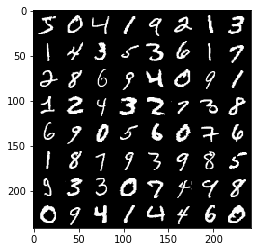

In [13]:
plt.imshow(make_grid(source).detach().numpy().transpose((1,2,0)))
plt.show()

In [14]:
_target = list_train_loader[0][1]
target = torch.zeros(_target.shape[0],10,dtype=torch.float32)
target[torch.arange(_target.shape[0],dtype=torch.long),_target] = 1.0

In [15]:
_target

tensor([ 5,  0,  4,  1,  9,  2,  1,  3,  1,  4,  3,  5,  3,  6,
         1,  7,  2,  8,  6,  9,  4,  0,  9,  1,  1,  2,  4,  3,
         2,  7,  3,  8,  6,  9,  0,  5,  6,  0,  7,  6,  1,  8,
         7,  9,  3,  9,  8,  5,  9,  3,  3,  0,  7,  4,  9,  8,
         0,  9,  4,  1,  4,  4,  6,  0])

In [17]:
target[:5]

tensor([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

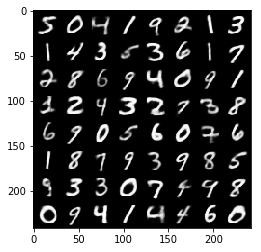

In [19]:
x = source.view(-1,28*28)
y = target
z_loc,z_scale = model.xy_to_z(x,y)
z = z_loc
x_p = model.yz_to_x(y,z)
x_recode = x_p

source_recode = x_recode.view(source.shape)
plt.imshow(make_grid(source_recode).detach().numpy().transpose(1,2,0))
plt.show()

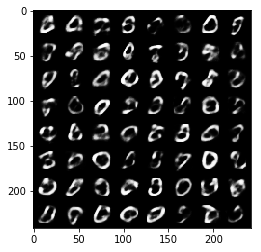

In [20]:
z = torch.randn(x.shape[0],20)
y = torch.zeros_like(target,dtype=torch.float32)
y[:,0] = 1.0

x_p = model.yz_to_x(y,z)
source_sample = x_p.view(source.shape)

plt.imshow(make_grid(source_sample).detach().numpy().transpose(1,2,0))
plt.show()

In [22]:
def sample_show(_y=0):
    z = torch.randn(x.shape[0],20)
    y = torch.zeros_like(target,dtype=torch.float32)
    y[:,_y] = 1.0

    x_p = model.yz_to_x(y,z)
    source_sample = x_p.view(source.shape)

    plt.imshow(make_grid(source_sample).detach().numpy().transpose(1,2,0))
    #plt.show()

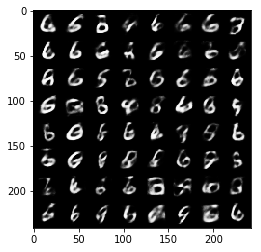

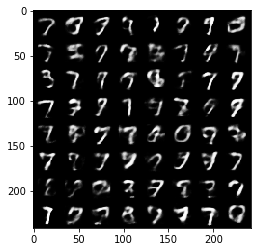

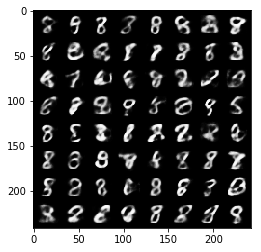

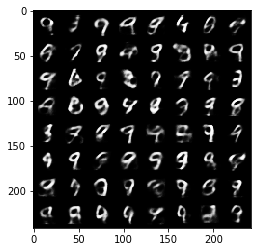

In [24]:
for i in range(6,10):
    sample_show(i)
    plt.show()

因为只训练了5个epoch所以其他几个实验效果，诸如固定z变化y，固定y套其他z，y直接插值渐变，z直接插值渐变，效果应该不会很好就不试了。
